In [1]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("ggplot")
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20

In [2]:
result_df = pd.read_csv("../output/result.csv")

## ユーザー数の変化

In [3]:
K = 10
n_doc = 50
optimizers = ["nsw", "ot_nsw"]

_result_df = result_df.query(
    "generator_K == @K & generator_n_doc == @n_doc & optimizer_name in @optimizers"
)

### 実行時間の変化

Text(0, 0.5, '実行時間 (s)')

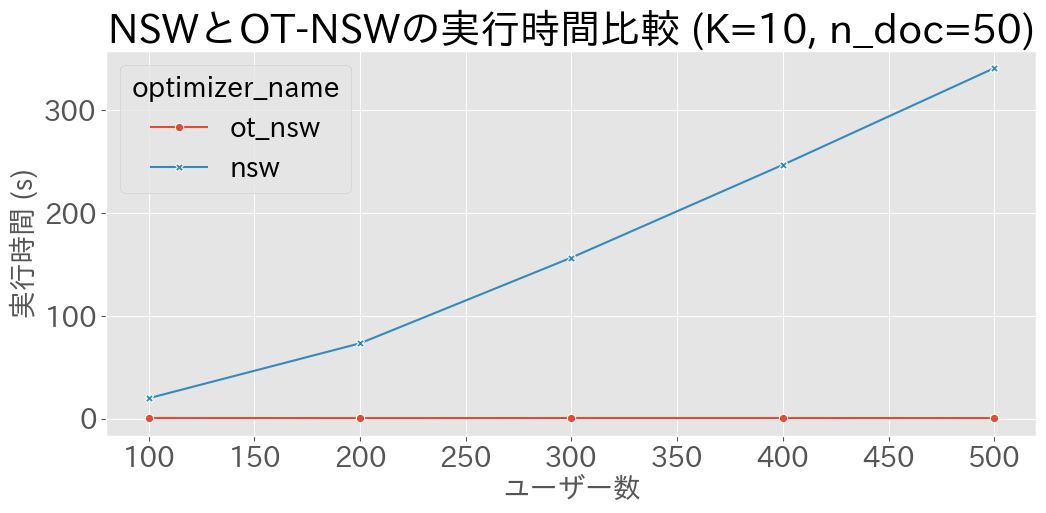

In [4]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="generator_n_query",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)
ax.set_title(f"NSWとOT-NSWの実行時間比較 (K={K}, n_doc={n_doc})")
ax.set_xlabel("ユーザー数")
ax.set_ylabel("実行時間 (s)")

Text(0, 0.5, '実行時間 (s)')

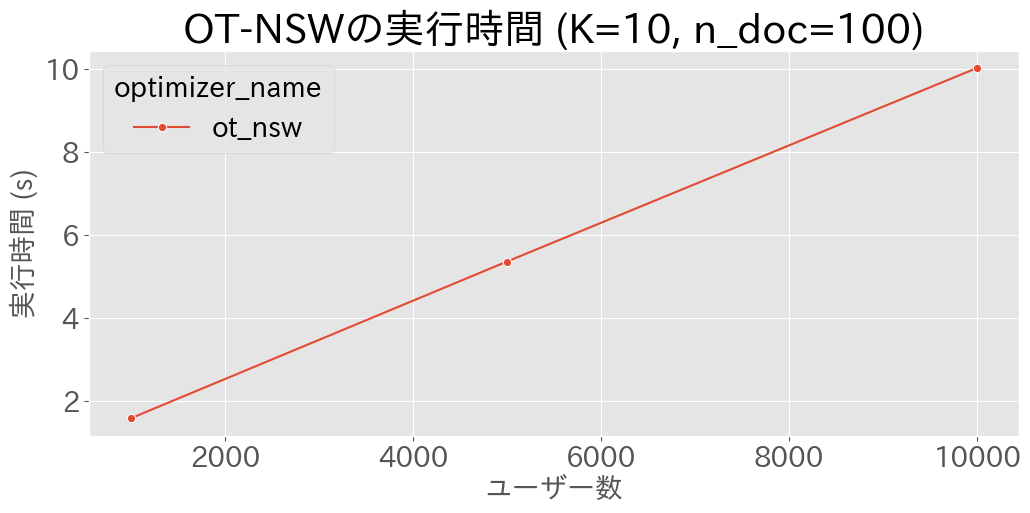

In [5]:
# ot_nsw only
K = 10
n_doc = 100
ot_nsw_result_df = result_df.query(
    "generator_K == @K & generator_n_doc == @n_doc & optimizer_name == 'ot_nsw'"
)

fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=ot_nsw_result_df,
    x="generator_n_query",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)

ax.set_title(f"OT-NSWの実行時間 (K={K}, n_doc={n_doc})")
ax.set_xlabel("ユーザー数")
ax.set_ylabel("実行時間 (s)")

### 精度の変化

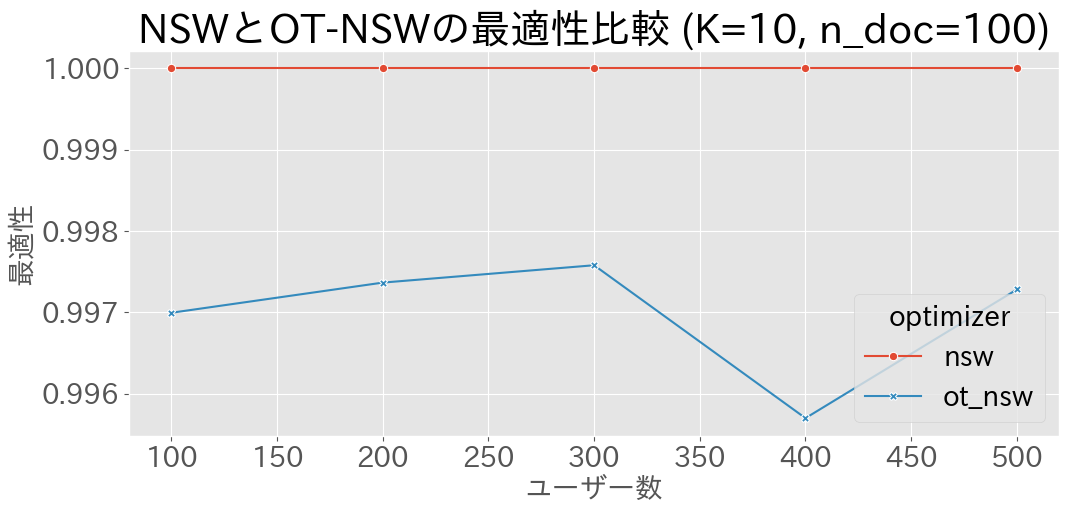

In [6]:
pdf = _result_df.pivot_table(index="generator_n_query", columns="optimizer_name", values="nsw")
pdf = pdf / pdf[["nsw"]].to_numpy()
_result_df = pdf.unstack().reset_index().rename(columns={0: "nsw"})

ax: plt.Axes
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="generator_n_query",
    y="nsw",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)
ax.set_title(f"NSWとOT-NSWの最適性比較 (K={K}, n_doc={n_doc})")
ax.set_xlabel("ユーザー数")
ax.set_ylabel("最適性")
ax.legend(title="optimizer")

## アイテム数の変化

In [7]:
K = 10
n_query = 500
optimizers = ["nsw", "ot_nsw"]

_result_df = result_df.query(
    "generator_K == @K & generator_n_query == @n_query & optimizer_name in @optimizers"
)

### 実行時間の変化

Text(0, 0.5, '実行時間 (s)')

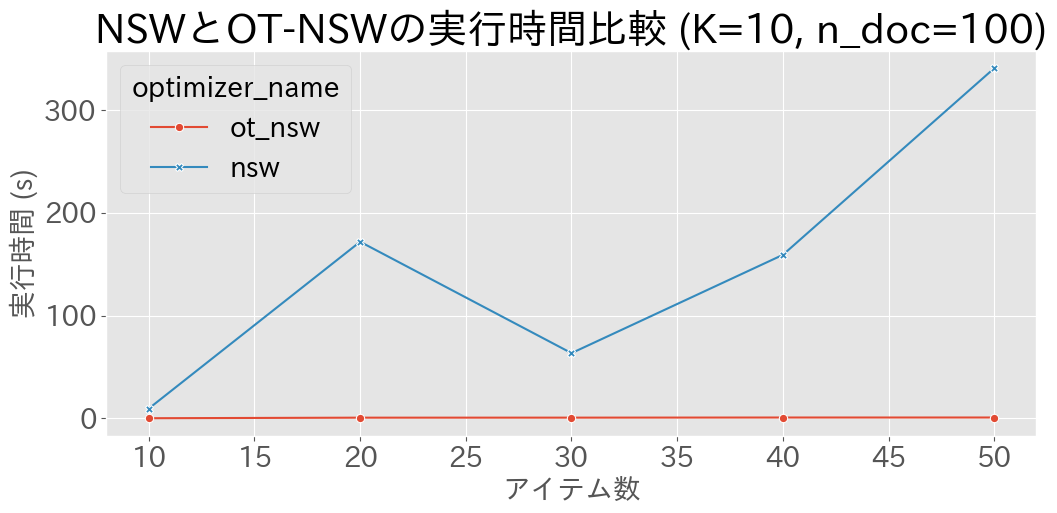

In [8]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="generator_n_doc",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)
ax.set_title(f"NSWとOT-NSWの実行時間比較 (K={K}, n_doc={n_doc})")
ax.set_xlabel("アイテム数")
ax.set_ylabel("実行時間 (s)")

Text(0, 0.5, '実行時間 (s)')

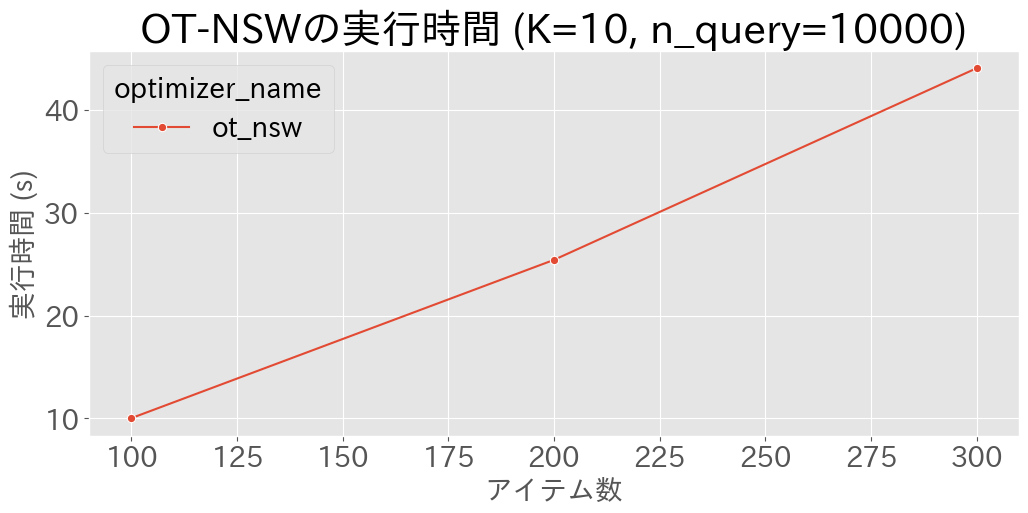

In [9]:
# ot_nsw only
K = 10
n_query = 10000
ot_nsw_result_df = result_df.query(
    "generator_K == @K & generator_n_query == @n_query & optimizer_name == 'ot_nsw'"
)

fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=ot_nsw_result_df,
    x="generator_n_doc",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)

ax.set_title(f"OT-NSWの実行時間 (K={K}, n_query={n_query})")
ax.set_xlabel("アイテム数")
ax.set_ylabel("実行時間 (s)")

## クラスタリングの数の変化

In [10]:
K = 20
n_query = 500
n_doc = 100
optimizers = ["clustered_nsw"]

_result_df = result_df.query(
    "generator_K == @K & generator_n_query == @n_query & generator_n_doc == @n_doc & optimizer_name in @optimizers"  # noqa
).copy()
_result_df["nsw"] = _result_df["nsw"] / _result_df["nsw"].max()

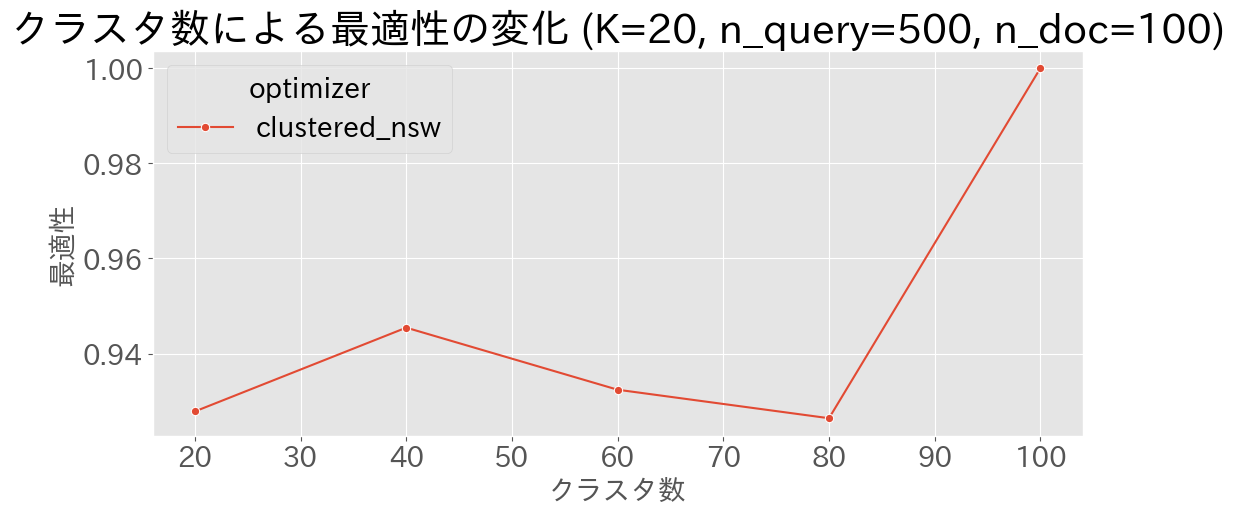

In [11]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="optimizer_params_n_doc_cluster",
    y="nsw",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)

ax.set_title(f"クラスタ数による最適性の変化 (K={K}, n_query={n_query}, n_doc={n_doc})")
ax.set_xlabel("クラスタ数")
ax.set_ylabel("最適性")
ax.legend(title="optimizer")

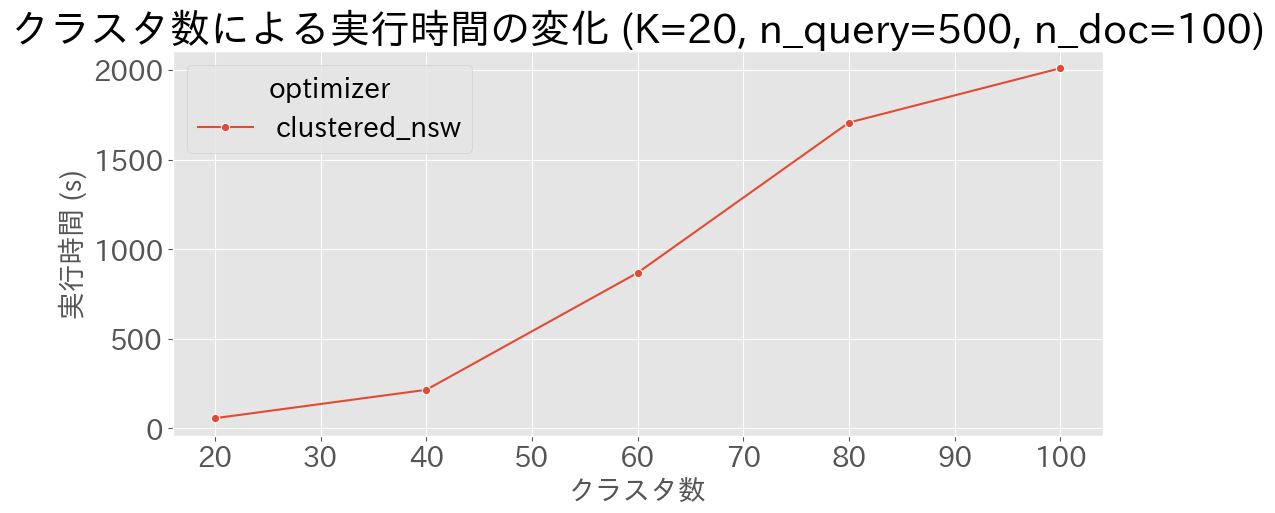

In [12]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="optimizer_params_n_doc_cluster",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)

ax.set_title(f"クラスタ数による実行時間の変化 (K={K}, n_query={n_query}, n_doc={n_doc})")
ax.set_xlabel("クラスタ数")
ax.set_ylabel("実行時間 (s)")
ax.legend(title="optimizer")

In [13]:
K = 20
n_query = 500
n_doc = 100
optimizers = ["clustered_nsw", "clustered_ot_nsw"]

_result_df = result_df.query(
    "generator_K == @K & generator_n_query == @n_query & generator_n_doc == @n_doc & optimizer_name in @optimizers"  # noqa
).copy()
_result_df["nsw"] = _result_df["nsw"] / _result_df["nsw"].max()

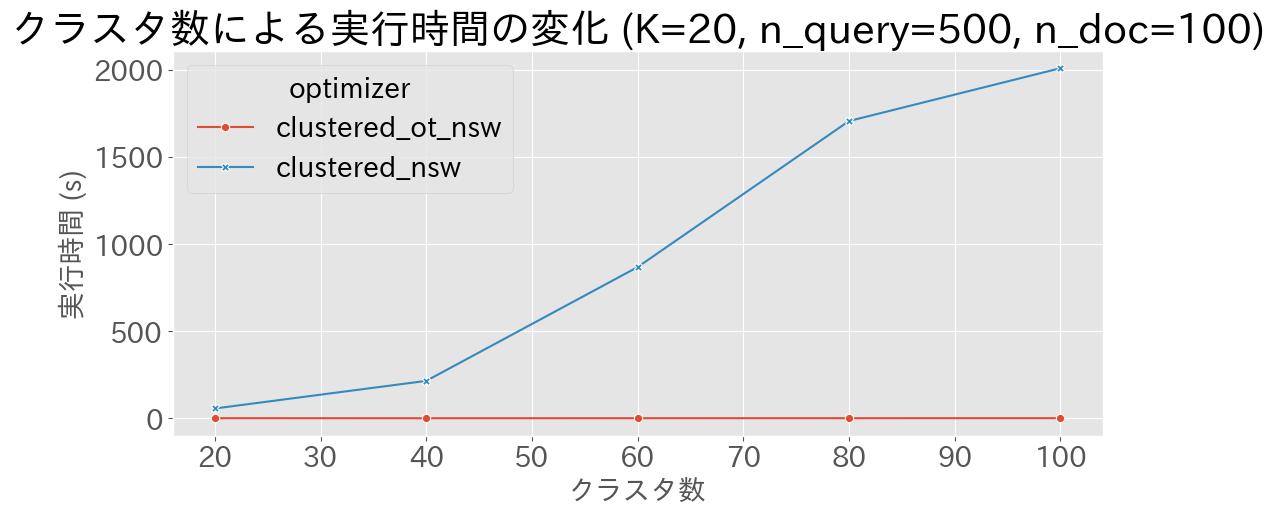

In [14]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(
    data=_result_df,
    x="optimizer_params_n_doc_cluster",
    y="exec_time",
    hue="optimizer_name",
    style="optimizer_name",
    markers=True,
    dashes=False,
    ax=ax,
)

ax.set_title(f"クラスタ数による実行時間の変化 (K={K}, n_query={n_query}, n_doc={n_doc})")
ax.set_xlabel("クラスタ数")
ax.set_ylabel("実行時間 (s)")
ax.legend(title="optimizer")